# Final project : Himalaya Expeditions

<h2>Table of Contents<span class="tocSkip"></span></h2>
<div class="toc"><li><span><a href="#Import Library" data-toc-modified-id="Import Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Library</a></span></li></ul>

<li><span><a href="#Load Data" data-toc-modified-id="Load Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li></ul>

<li><span><a href="#Data Cleaning" data-toc-modified-id="Data Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul>

<li><span><a href="#Call API's" data-toc-modified-id="Call API's-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Call API's</a></span></li></ul>

<li><span><a href="#Web scraping" data-toc-modified-id="Web scraping-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Web craping</a></span></li></ul>

<li><span><a href="#Connection to SQL" data-toc-modified-id="Connection to SQL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Connection to SQL</a></span></li></ul>

<li><span><a href="#Connection to Big Query" data-toc-modified-id="Connection to Big Query-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Connection to Big Query</a></span></li></ul>

<li><span><a href="#EDA" data-toc-modified-id="EDA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>EDA</a></span></li></ul>

</li></ul></div>

## 1 - Import Library : 

In [28]:
#installation : 
#pip install geopy
#pip install pyarrow pandas-gbq

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time
import requests
from sqlalchemy import create_engine, text 
import os
from google.cloud import bigquery
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as st
from bs4 import BeautifulSoup

## 2 - Load Data :

In [29]:
expedition_df = pd.read_csv('csv/expeditions.csv')
members_df = pd.read_csv('csv/members.csv')
p_df = pd.read_csv('csv/peaks0.csv') # csv from other database to catch location & region
peaks_df = pd.read_csv('csv/peaks.csv')
gps_df = pd.read_csv('csv/peak_gps.csv') # GPS coordinates from API


## 3 - Data cleaning : 

In [4]:
#shape : 
print (f'expedition : {expedition_df.shape}')
print (f'members : {members_df.shape}')
print (f'peaks : {peaks_df.shape}')


expedition : (10364, 16)
members : (76519, 21)
peaks : (468, 8)


In [5]:
#null values : 
print (f'expedition : {expedition_df.isnull().sum()}')
print (f'members : {members_df.isnull().sum()}')
print (f'peaks : {peaks_df.isnull().sum()}')

expedition : expedition_id            0
peak_id                  0
peak_name                1
year                     0
season                   0
basecamp_date         1095
highpoint_date         650
termination_date      2380
termination_reason       0
highpoint_metres       414
members                  0
member_deaths            0
hired_staff              0
hired_staff_deaths       0
oxygen_used              0
trekking_agency       1710
dtype: int64
members : expedition_id               0
member_id                   0
peak_id                     0
peak_name                  15
year                        0
season                      0
sex                         2
age                      3497
citizenship                10
expedition_role            21
hired                       0
highpoint_metres        21833
success                     0
solo                        0
oxygen_used                 0
died                        0
death_cause             75413
death_height_metres   

In [6]:
#check duplicated rows : 
print (f'expedition : {expedition_df.duplicated().sum()}')
print (f'peaks : {peaks_df.duplicated().sum()}')
print (f'members : {members_df.duplicated().sum()}')

expedition : 0
peaks : 0
members : 0


In [7]:
# df_expedition : formatting datetime, add is_sucess column : 
expedition_df['basecamp_date'] = pd.to_datetime(expedition_df['basecamp_date'], errors='coerce')
expedition_df['highpoint_date'] = pd.to_datetime(expedition_df['highpoint_date'], errors='coerce')
expedition_df['termination_date'] = pd.to_datetime(expedition_df['termination_date'], errors='coerce')
expedition_df['is_success'] = expedition_df['termination_reason'].apply(lambda x: True if x == 'Success (main peak)' else False)
print(expedition_df.dtypes)
expedition_df.head()


expedition_id                 object
peak_id                       object
peak_name                     object
year                           int64
season                        object
basecamp_date         datetime64[ns]
highpoint_date        datetime64[ns]
termination_date      datetime64[ns]
termination_reason            object
highpoint_metres             float64
members                        int64
member_deaths                  int64
hired_staff                    int64
hired_staff_deaths             int64
oxygen_used                     bool
trekking_agency               object
is_success                      bool
dtype: object


,expedition_id,peak_id,peak_name,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,highpoint_metres,members,member_deaths,hired_staff,hired_staff_deaths,oxygen_used,trekking_agency,is_success
0,ANN260101,ANN2,Annapurna II,1960,Spring,1960-03-15,1960-05-17,NaT,Success (main peak),7937.0,10,0,9,0,True,NaN,True
1,ANN269301,ANN2,Annapurna II,1969,Autumn,1969-09-25,1969-10-22,1969-10-26,Success (main peak),7937.0,10,0,0,0,False,NaN,True
2,ANN273101,ANN2,Annapurna II,1973,Spring,1973-03-16,1973-05-06,NaT,Success (main peak),7937.0,6,0,8,0,False,NaN,True
3,ANN278301,ANN2,Annapurna II,1978,Autumn,1978-09-08,1978-10-02,1978-10-05,"Bad weather (storms, high winds)",7000.0,2,0,0,0,False,NaN,False
4,ANN279301,ANN2,Annapurna II,1979,Autumn,NaT,1979-10-18,1979-10-20,"Bad weather (storms, high winds)",7160.0,3,0,0,0,False,NaN,False


In [8]:
# info members_df
print(members_df.dtypes)
members_df.head()

expedition_id            object
member_id                object
peak_id                  object
peak_name                object
year                      int64
season                   object
sex                      object
age                     float64
citizenship              object
expedition_role          object
hired                      bool
highpoint_metres        float64
success                    bool
solo                       bool
oxygen_used                bool
died                       bool
death_cause              object
death_height_metres     float64
injured                    bool
injury_type              object
injury_height_metres    float64
dtype: object


,expedition_id,member_id,peak_id,peak_name,year,season,sex,age,citizenship,expedition_role,...,highpoint_metres,success,solo,oxygen_used,died,death_cause,death_height_metres,injured,injury_type,injury_height_metres
0,AMAD78301,AMAD78301-01,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Leader,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
1,AMAD78301,AMAD78301-02,AMAD,Ama Dablam,1978,Autumn,M,41.0,France,Deputy Leader,...,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
2,AMAD78301,AMAD78301-03,AMAD,Ama Dablam,1978,Autumn,M,27.0,France,Climber,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN
3,AMAD78301,AMAD78301-04,AMAD,Ama Dablam,1978,Autumn,M,40.0,France,Exp Doctor,...,6000.0,False,False,False,False,NaN,NaN,False,NaN,NaN
4,AMAD78301,AMAD78301-05,AMAD,Ama Dablam,1978,Autumn,M,34.0,France,Climber,...,NaN,False,False,False,False,NaN,NaN,False,NaN,NaN


In [9]:
peaks_df.head()
peaks_df = peaks_df.merge(p_df[['peak_id','location', 'region']], on='peak_id', how='left')

In [10]:
print(peaks_df.dtypes)

peak_id                        object
peak_name                      object
peak_alternative_name          object
height_metres                   int64
climbing_status                object
first_ascent_year             float64
first_ascent_country           object
first_ascent_expedition_id     object
location                       object
region                         object
dtype: object


In [11]:
#isna expedition : check null value

# Replace null value by median for numerical column
numeric_cols = expedition_df.select_dtypes(include=['float64', 'int64']).columns
expedition_df[numeric_cols] = expedition_df[numeric_cols].fillna(expedition_df[numeric_cols].median())

# Replace null value by "Unknown" for categorical column
categorical_cols = expedition_df.select_dtypes(include=['object']).columns
expedition_df[categorical_cols] = expedition_df[categorical_cols].fillna("Unknown")

# manage null basecamp_date (avg date per year + season)
mean_basecamp_date = expedition_df.groupby(['year', 'season'])['basecamp_date'].transform('mean')
mean_basecamp_date = mean_basecamp_date.dt.floor('D')
expedition_df['basecamp_date'] = pd.to_datetime(expedition_df['basecamp_date'], errors='coerce')

# manage null hightpoint_date (avf diff)
mean_highpoint_diff = (expedition_df['highpoint_date'] - expedition_df['basecamp_date']).dt.days.mean()
expedition_df['highpoint_date'].fillna(expedition_df['basecamp_date'] + pd.to_timedelta(mean_highpoint_diff, unit='D'), inplace=True)

# manage null termination_date (avg diff)
mean_termination_diff = (expedition_df['termination_date'] - expedition_df['basecamp_date']).dt.days.mean()
expedition_df['termination_date'].fillna(expedition_df['basecamp_date'] + pd.to_timedelta(mean_termination_diff, unit='D'), inplace=True)
expedition_df['termination_date'] = pd.to_datetime(expedition_df['termination_date'], errors='coerce')
expedition_df['termination_date'] = expedition_df['termination_date'].dt.date

# drop null value
expedition_df = expedition_df.dropna()
print (f'expedition : {expedition_df.isnull().sum()}')
expedition_df


expedition : expedition_id         0
peak_id               0
peak_name             0
year                  0
season                0
basecamp_date         0
highpoint_date        0
termination_date      0
termination_reason    0
highpoint_metres      0
members               0
member_deaths         0
hired_staff           0
hired_staff_deaths    0
oxygen_used           0
trekking_agency       0
is_success            0
dtype: int64


,expedition_id,peak_id,peak_name,year,season,basecamp_date,highpoint_date,termination_date,termination_reason,highpoint_metres,members,member_deaths,hired_staff,hired_staff_deaths,oxygen_used,trekking_agency,is_success
0,ANN260101,ANN2,Annapurna II,1960,Spring,1960-03-15,1960-05-17,1960-04-10,Success (main peak),7937.0,10,0,9,0,True,Unknown,True
1,ANN269301,ANN2,Annapurna II,1969,Autumn,1969-09-25,1969-10-22,1969-10-26,Success (main peak),7937.0,10,0,0,0,False,Unknown,True
2,ANN273101,ANN2,Annapurna II,1973,Spring,1973-03-16,1973-05-06,1973-04-11,Success (main peak),7937.0,6,0,8,0,False,Unknown,True
3,ANN278301,ANN2,Annapurna II,1978,Autumn,1978-09-08,1978-10-02,1978-10-05,"Bad weather (storms, high winds)",7000.0,2,0,0,0,False,Unknown,False
5,ANN280101,ANN2,Annapurna II,1980,Spring,1980-03-25,1980-04-24,1980-05-01,Accident (death or serious injury),7000.0,6,1,2,0,False,Unknown,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10359,PUMO19101,PUMO,Pumori,2019,Spring,2019-04-04,2019-05-01,2019-05-27,Success (main peak),7138.0,8,0,4,0,False,Mountain Experience,True
10360,PUMO19102,PUMO,Pumori,2019,Spring,2019-04-14,2019-05-01,2019-05-25,Success (main peak),7138.0,1,0,1,0,False,Asian Trekking,True
10361,PUTH19101,PUTH,Putha Hiunchuli,2019,Spring,2019-05-09,2019-05-16,2019-05-17,"Bad conditions (deep snow, avalanching, fallin...",6350.0,5,0,2,0,False,Iceland Trekking,False
10362,RATC19101,RATC,Ratna Chuli,2019,Spring,2019-04-11,2019-04-19,2019-05-03,Lack (or loss) of supplies or equipment,6600.0,1,0,0,0,False,Pioneer Adventure,False


In [12]:
#isna peaks : check null value
categorical_cols = peaks_df.select_dtypes(include=['object']).columns
peaks_df[categorical_cols] = peaks_df[categorical_cols].fillna("Unknown")
print (f'peaks : {peaks_df.isnull().sum()}')

peaks : peak_id                         0
peak_name                       0
peak_alternative_name           0
height_metres                   0
climbing_status                 0
first_ascent_year             132
first_ascent_country            0
first_ascent_expedition_id      0
location                        0
region                          0
dtype: int64


In [13]:
#isna members : check null value
# replace missing values by 0 for 'death_height_metres' et 'injury_height_metres'
members_df[['death_height_metres', 'injury_height_metres']] = members_df[['death_height_metres', 'injury_height_metres']].fillna(0)

# replace missing values by mediane for 'age' et 'highpoint_metres'
members_df['age'] = members_df['age'].fillna(members_df['age'].median())
members_df['highpoint_metres'] = members_df['highpoint_metres'].fillna(members_df['highpoint_metres'].median())

# Replace null value by "Unknown" for other categorical column
members_df[['peak_name', 'citizenship', 'expedition_role','death_cause','injury_type']] = members_df[['peak_name', 'citizenship', 'expedition_role','death_cause','injury_type']].fillna(0)
# drop 2 rows with sex null 
members_df = members_df.dropna()
print (f'expedition : {members_df.isnull().sum()}')

expedition : expedition_id           0
member_id               0
peak_id                 0
peak_name               0
year                    0
season                  0
sex                     0
age                     0
citizenship             0
expedition_role         0
hired                   0
highpoint_metres        0
success                 0
solo                    0
oxygen_used             0
died                    0
death_cause             0
death_height_metres     0
injured                 0
injury_type             0
injury_height_metres    0
dtype: int64


## 4- Call API's

A- Nominatim API : get coordinates

In [14]:
# API Nominatim Option 1 
geolocator = Nominatim(user_agent="my_himalayan_expedition_app", timeout=10)

# Fonction pour obtenir les coordonnées
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        print("Timeout occurred. Retrying...")
        time.sleep(1)
        return get_coordinates(address)  # Retry once after a short delay
    except GeocoderServiceError as e:
        print(f"Geocoding service error: {e}")
        return None, None

# Ajoutez les colonnes pour les coordonnées
peaks_df['latitude'] = None
peaks_df['longitude'] = None

# Obtenez les coordonnées pour chaque sommet et mettez à jour le DataFrame
for index, row in peaks_df.iterrows():
    peak = row['peak_name']
    lat, lon = get_coordinates(peak)
    if lat is not None and lon is not None:
        peaks_df.at[index, 'latitude'] = lat
        peaks_df.at[index, 'longitude'] = lon
        print(f"{peak}: {lat}, {lon}")
    else:
        print(f"{peak}: coordinates not found")

# Affichez le DataFrame mis à jour
print(peaks_df)
peaks_df.to_csv('csv/peak_gps.csv')

Ama Dablam: 27.8621001, 86.8604289
Amphu Gyabjen: 27.8812212, 86.8687897
Annapurna I: 28.5958063, 83.8199199
Annapurna II: 45.9193991, 6.8657575
Annapurna III: 28.5853509, 83.9891091
Annapurna IV: 28.5368932, 84.0835623
Annapurna I East: 51.5640387, -1.7519405
Annapurna I Middle: coordinates not found
Annapurna South: 28.5183959, 83.8063433
Api Main: 47.5603035, -1.025273378651685
Api West: 1.3324349, 103.63288815976227
Baruntse: 27.8720615, 86.9796489
Baudha: 27.7205626, 85.3617188
Bhemdang Ri: 28.2721381, 85.6635329
Bhrikuti: 27.6307699, 83.4769766
Bobaye: 10.4330167, 21.27055
Chamlang: 27.7769937, 86.9810557
Changla: 24.45932835, 73.49460664228269
Chamar North: 35.4623305, -80.6827327
Cheo Himal: coordinates not found
Cho Oyu: 28.0967465, 86.659634
Chobuje: 27.8814373, 86.4892244
Cholatse: 27.9196156, 86.7651758
Cho Polu: 27.9194539, 86.9819868
Chulu Central: -12.8241485, 33.3069523
Chukyima Go: coordinates not found
Churen Himal Central: coordinates not found
Chulu West: 28.7454053

In [15]:
peaks_df.head()

,peak_id,peak_name,peak_alternative_name,height_metres,climbing_status,first_ascent_year,first_ascent_country,first_ascent_expedition_id,location,region,latitude,longitude
0,AMAD,Ama Dablam,Amai Dablang,6814,Climbed,1961.0,"New Zealand, USA, UK",AMAD61101,Khumbu,Khumbu-Rolwaling-Makalu,27.8621,86.860429
1,AMPG,Amphu Gyabjen,Unknown,5630,Climbed,1953.0,UK,AMPG53101,Khumbu,Khumbu-Rolwaling-Makalu,27.881221,86.86879
2,ANN1,Annapurna I,Unknown,8091,Climbed,1950.0,France,ANN150101,Annapurna,Annapurna-Damodar-Peri,28.595806,83.81992
3,ANN2,Annapurna II,Unknown,7937,Climbed,1960.0,"UK, Nepal",ANN260101,Annapurna,Annapurna-Damodar-Peri,45.919399,6.865757
4,ANN3,Annapurna III,Unknown,7555,Climbed,1961.0,India,ANN361101,Annapurna,Annapurna-Damodar-Peri,28.585351,83.989109


In [16]:
# check latitude & longitude not found
print (f'peaks : {peaks_df.isnull().sum()}')
peaks_df.head()


peaks : peak_id                         0
peak_name                       0
peak_alternative_name           0
height_metres                   0
climbing_status                 0
first_ascent_year             132
first_ascent_country            0
first_ascent_expedition_id      0
location                        0
region                          0
latitude                      213
longitude                     213
dtype: int64


,peak_id,peak_name,peak_alternative_name,height_metres,climbing_status,first_ascent_year,first_ascent_country,first_ascent_expedition_id,location,region,latitude,longitude
0,AMAD,Ama Dablam,Amai Dablang,6814,Climbed,1961.0,"New Zealand, USA, UK",AMAD61101,Khumbu,Khumbu-Rolwaling-Makalu,27.8621,86.860429
1,AMPG,Amphu Gyabjen,Unknown,5630,Climbed,1953.0,UK,AMPG53101,Khumbu,Khumbu-Rolwaling-Makalu,27.881221,86.86879
2,ANN1,Annapurna I,Unknown,8091,Climbed,1950.0,France,ANN150101,Annapurna,Annapurna-Damodar-Peri,28.595806,83.81992
3,ANN2,Annapurna II,Unknown,7937,Climbed,1960.0,"UK, Nepal",ANN260101,Annapurna,Annapurna-Damodar-Peri,45.919399,6.865757
4,ANN3,Annapurna III,Unknown,7555,Climbed,1961.0,India,ANN361101,Annapurna,Annapurna-Damodar-Peri,28.585351,83.989109


## 5- Web scraping

In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.topchinatravel.com/mount-everest/the-climate-of-mount-everest.htm'

# get request
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# find table on web page
tables = soup.find_all('table')

# convert html table in DF-
def parse_html_table(table):
    rows = table.find_all('tr')
    data = []
    for row in rows:
        data.append([td.text.strip() for td in row.find_all('td')])
    return pd.DataFrame(data)

# Scrapper 2 first table
season_climate = parse_html_table(tables[0]).drop(0)
season_climate= season_climate.transpose()
season_climate.columns = season_climate.iloc[0]
season_climate = season_climate.drop(season_climate.index[0])
season_climate = season_climate.assign(peak_id='EVER')
season_climate[['Celsius', 'Fahrenheit']] = season_climate[['Celsius', 'Fahrenheit']].astype(float)

weather_period_everest = parse_html_table(tables[1])
weather_period_everest = weather_period_everest.drop(0)
weather_period_everest.reset_index(drop=True, inplace=True)
weather_period_everest.columns = ["season","climate","windows_date"]
weather_period_everest = weather_period_everest.assign(peak_id='EVER')

season_climate.to_csv('csv/season_climate.csv')
weather_period_everest.to_csv('csv/weather_period_everest.csv')


display(season_climate)
display(weather_period_everest)


,Type,Celsius,Fahrenheit,peak_id
1,July,-18.0,-0.4,EVER
2,Aug,-18.0,-0.4,EVER
3,Sept,-21.0,-5.8,EVER
4,Oct,-27.0,-16.6,EVER
5,Nov,-30.0,-22.0,EVER
6,Dec,-34.0,-29.2,EVER
7,Jan,-36.0,-32.8,EVER
8,Feb,-35.0,-31.0,EVER
9,Mar,-32.0,-25.6,EVER
10,Apr,-31.0,-23.8,EVER


,season,climate,windows_date,peak_id
0,Summer,Very Wet,June 7 to Sep 30,EVER
1,Autumn Window,"Dry, Warm, Calm",Oct 1 to Oct 20,EVER
2,Autumn,"Very Windy, Cold, Very Dry, Dark",Oct 20 to Nov 30,EVER
3,Winter,"Very Windy, Very Cold, Dry, Dark",Dec 1 to Feb 28,EVER
4,Spring,"Windy, Cold, Dry",Mar 1 to May 20,EVER
5,Spring Window,"Dry, Warm, Calm",May 20 to June 6,EVER


## 6- Connection to SQL

In [18]:
pw = os.getenv('my_SQL_pw')
pw = urllib.parse.quote_plus(pw)

In [19]:
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/'
engine = create_engine(connection_string)

In [20]:
expedition_df.to_sql(name='expedition', con=engine, schema='himalaya', index=False, if_exists='replace')
members_df.to_sql(name='members', con=engine, schema='himalaya', index=False, if_exists='replace')
peaks_df.to_sql(name='peaks', con=engine, schema='himalaya', index=False, if_exists='replace')
weather_period_everest.to_sql(name='weather_period', con=engine, schema='himalaya', index=False, if_exists='replace')
season_climate.to_sql(name='season_climate', con=engine, schema='himalaya', index=False, if_exists='replace')

12

## 7- Connection to Big Query

In [26]:
# Initialisation du client BigQuery
client = bigquery.Client()

# Définition des informations de votre projet et dataset
project_id = 'da-bootcamp-2023'
dataset_id = f'{project_id}.nivault'

# Création du dataset
dataset = bigquery.Dataset(dataset_id)
dataset.location = 'US'  # ou autre région appropriée
dataset = client.create_dataset(dataset, exists_ok=True)
print(f"Dataset {dataset.dataset_id} créé ou existe déjà.")

# Fonction pour corriger les types de colonnes
def correct_data_types(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('string')  # Convertir les colonnes object en string
    return df

# Fonction pour charger un DataFrame dans une table BigQuery
def load_df_to_bq(dataframe, table_id):
    dataframe.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f"Table {table_id} créée et données chargées.")

# Correction des types de colonnes + creation d'un nouveau DF_bq
members_bq = correct_data_types(members_df)
peaks_bq = correct_data_types(peaks_df)

# Liste des DataFrames et des noms de tables correspondants
dataframes_and_tables = [
    (members_bq, 'nivault.members'),
    (peaks_bq, 'nivault.peaks'),
]

# Chargement des DataFrames dans les tables BigQuery
for dataframe, table in dataframes_and_tables:
    try:
        load_df_to_bq(dataframe, table)
    except Exception as e:
        print(f"Erreur lors du chargement de la table {table}: {e}")


Dataset nivault créé ou existe déjà.
Erreur lors du chargement de la table nivault.expedition: Could not convert DataFrame to Parquet.


100%|██████████| 1/1 [00:00<00:00, 615.81it/s]


Table nivault.members créée et données chargées.


100%|██████████| 1/1 [00:00<?, ?it/s]

Table nivault.peaks créée et données chargées.


## 8- EDA

### Visualizations 

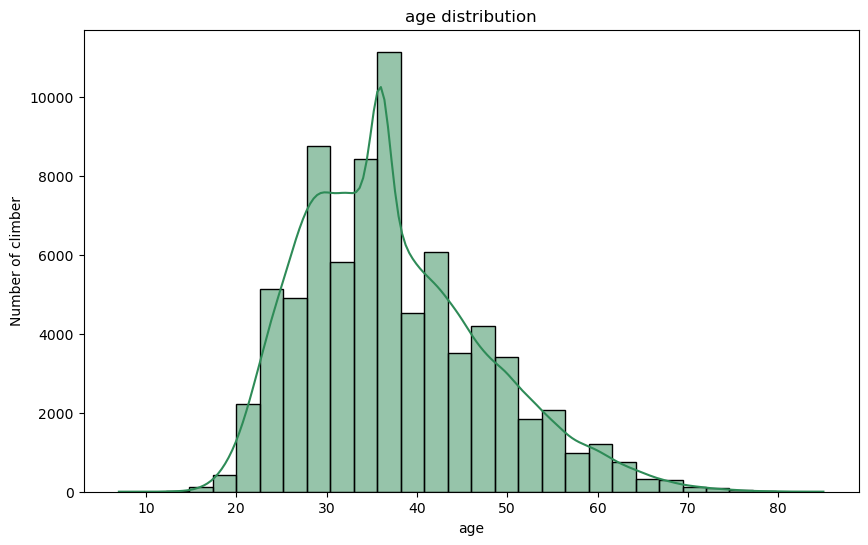

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=members_df, x='age', bins=30, kde=True, color="seagreen")
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('Number of climber')
plt.show()

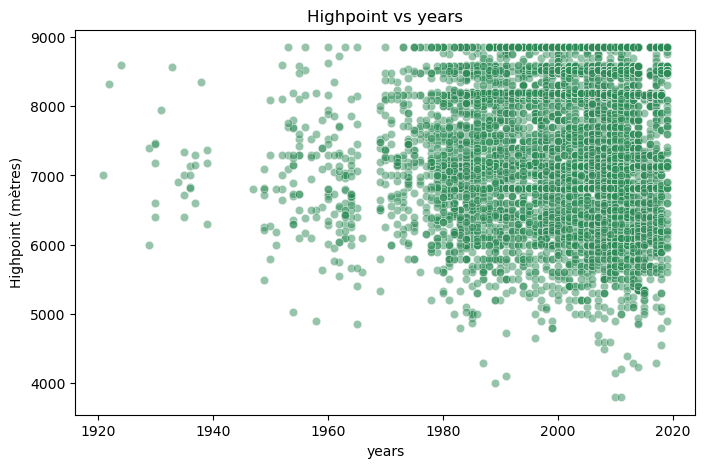

In [ ]:
# retravailler 
plt.figure(figsize=(8, 5))
sns.scatterplot(data=expedition_df, y='highpoint_metres', x='year', alpha=0.5, color = "seagreen")
plt.title('Highpoint vs years')
plt.ylabel('Highpoint (mètres)')
plt.xlabel('years')
plt.show()

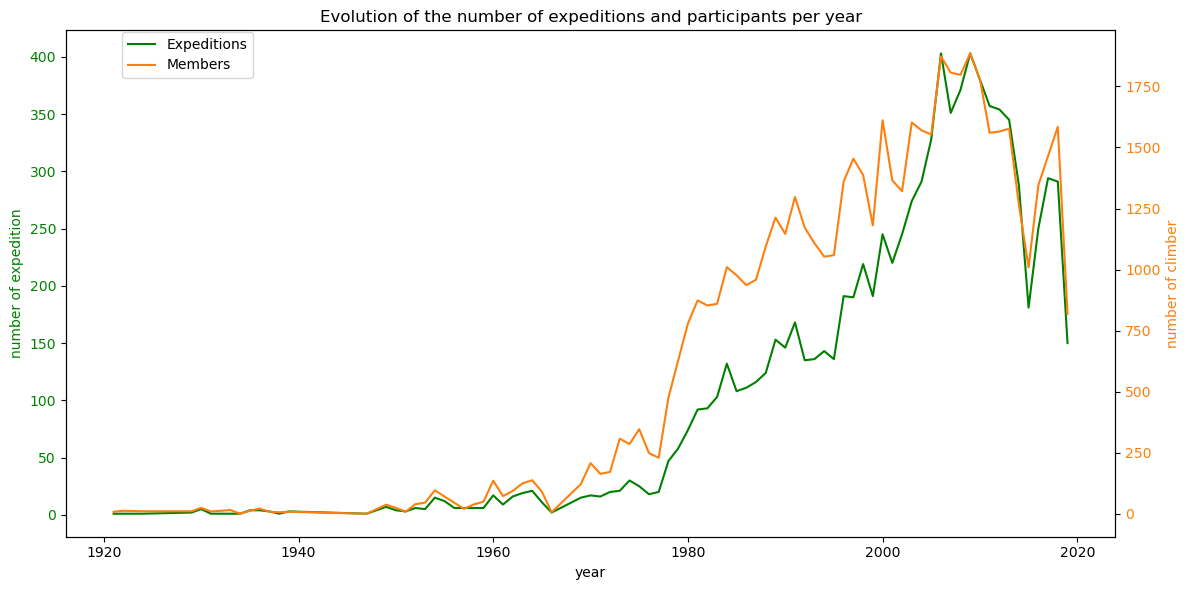

In [ ]:
expeditions_per_year = expedition_df.groupby('year').agg({
    'expedition_id': 'count',
    'members': 'sum'
}).reset_index()

expeditions_per_year.columns = ['year', 'num_expeditions', 'num_participants']

# Créer le graphique
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe pour le nombre d'expéditions
color = 'green'
ax1.set_xlabel('year')
ax1.set_ylabel('number of expedition', color=color)
ax1.plot(expeditions_per_year['year'], expeditions_per_year['num_expeditions'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Créer un deuxième axe y pour le nombre de participants
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('number of climber', color=color)
ax2.plot(expeditions_per_year['year'], expeditions_per_year['num_participants'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
plt.title('Evolution of the number of expeditions and participants per year')
fig.tight_layout()
fig.legend(['Expeditions', 'Members'], loc='upper left', bbox_to_anchor=(0.1, 0.95))

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11348\2717643291.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='season', y='highpoint_metres', data=expedition_df,


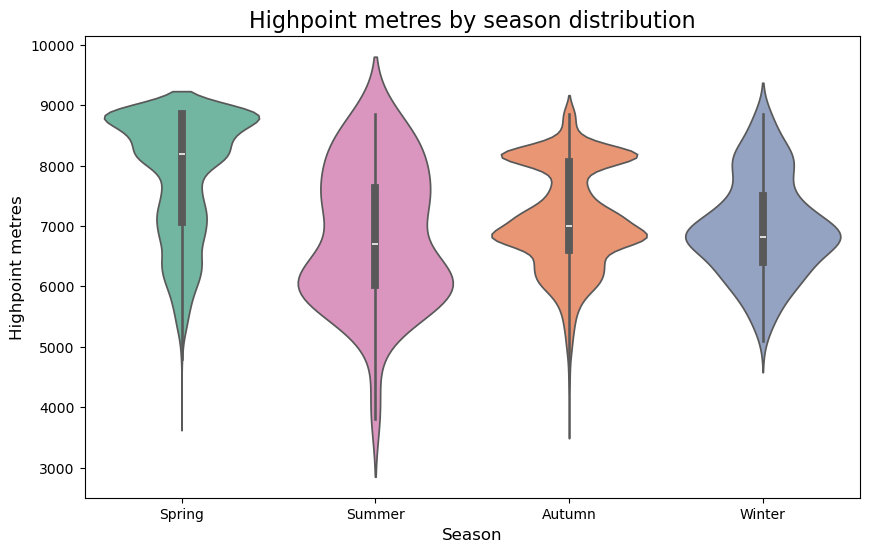

In [ ]:
custom_palette = {
    'Spring': '#66c2a5',  # Vert  
    'Summer': '#e78ac3',  # Rose 
    'Autumn': '#fc8d62',  # Orange 
    'Winter': '#8da0cb'   # Bleu 
}

# Créer le graphique
plt.figure(figsize=(10, 6))
sns.violinplot(x='season', y='highpoint_metres', data=expedition_df, 
               palette=custom_palette, order=['Spring', 'Summer', 'Autumn', 'Winter'])

plt.title('Highpoint metres by season distribution', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Highpoint metres', fontsize=12)

plt.show()

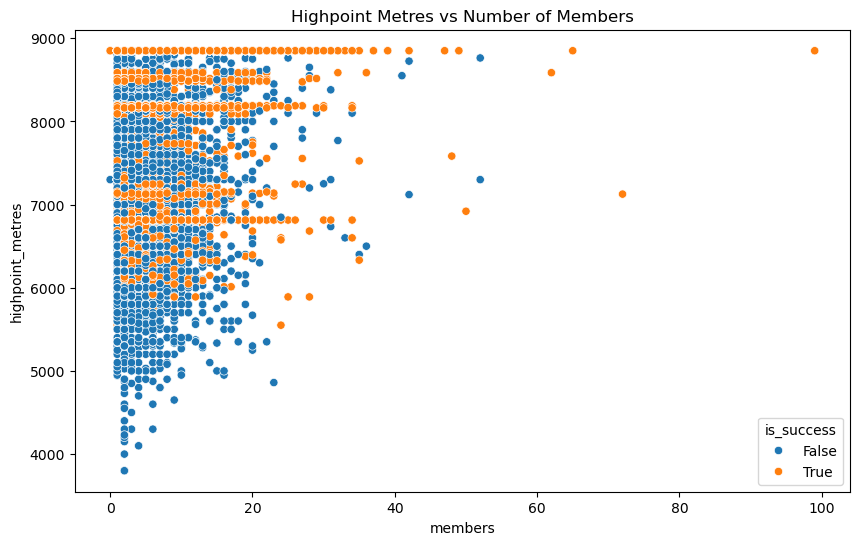

In [ ]:
# Scatterplot pour deux variables numériques
plt.figure(figsize=(10, 6))
sns.scatterplot(x='members', y='highpoint_metres', data=expedition_df, hue='is_success')
plt.title('Highpoint Metres vs Number of Members')
plt.show()

### Statistics

In [ ]:

numeric_cols = ['highpoint_metres', 'age']
display(members_df[numeric_cols].describe())

numeric_cols2 = ['members', 'hired_staff']
display(expedition_df[numeric_cols2].describe())


,highpoint_metres,age
count,76517.000000,76517.000000
mean,7450.555458,37.273351
std,879.801022,10.159229
min,3800.000000,7.000000
25%,6814.000000,30.000000
50%,7400.000000,36.000000
75%,8167.000000,43.000000
max,8850.000000,85.000000


,members,hired_staff
count,9269.000000,9269.000000
mean,6.108318,2.875823
std,5.396726,5.041777
min,0.000000,0.000000
25%,2.000000,0.000000
50%,5.000000,2.000000
75%,8.000000,3.000000
max,99.000000,99.000000


In [ ]:
categorical_cols = ['season', 'peak_name', 'is_success','oxygen_used']
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    display(expedition_df[col].value_counts(normalize=True))


Distribution of season:


season
Autumn    0.482792
Spring    0.477182
Winter    0.031827
Summer    0.008199
Name: proportion, dtype: float64


Distribution of peak_name:


peak_name
Everest           0.217068
Cho Oyu           0.136261
Ama Dablam        0.125796
Manaslu           0.064085
Lhotse            0.041536
                    ...   
Shalbachum        0.000108
Pharilapcha       0.000108
Chako             0.000108
Ghhanyala Hies    0.000108
Sano Kailash      0.000108
Name: proportion, Length: 365, dtype: float64


Distribution of is_success:


is_success
True     0.553997
False    0.446003
Name: proportion, dtype: float64


Distribution of oxygen_used:


oxygen_used
False    0.697702
True     0.302298
Name: proportion, dtype: float64

In [ ]:
# Test du chi-carré pour l'indépendance

contingency_table = pd.crosstab(expedition_df['season'], expedition_df['is_success'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value for correlation between success et season: {p_value}")

contingency_table = pd.crosstab(expedition_df['oxygen_used'], expedition_df['is_success'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test p-value for correlation between success et oxygen: {p_value}")

# We reject the null hypothesis, which means that season and success are most likely correlated
# We reject the null hypothesis, which means that oxygen_used and success are most likely correlated.

Chi-square test p-value for correlation between success et season: 1.740534396928738e-08
Chi-square test p-value for correlation between success et oxygen: 1.1467904824516018e-183


In [ ]:
# Two Sample T-test
df_female = members_df[members_df["sex"]=="F"]["highpoint_metres"]
df_male = members_df[members_df["sex"]=="M"]["highpoint_metres"]

#Set the hypothesis

#H0: highpoint male = highpoint female
#H1: highpoint male != highpoint female

#significance level = 0.05

result = st.ttest_ind(df_male,df_female, equal_var=False)

p_value = result.pvalue

if p_value > 0.05:
    print("We are not able to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


In [ ]:
# Two Sample T-test
df_staff = members_df[members_df["hired"]=="1"]["age"]
df_climber = members_df[members_df["hired"]=="0"]["age"]

#Set the hypothesis

#H0: avg age staff = avg age climber
#H1: avg age climber != avg age climber

#significance level = 0.05

result = st.ttest_ind(df_staff,df_climber, equal_var=False)

p_value = result.pvalue

if p_value > 0.05:
    print("We are not able to reject the null hypothesis")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


## 9- Machin Learning